In [23]:
import sys
sys.path.append('/home/rwb/github/skaworkflows')

import logging
import json

from pathlib import Path


logging.basicConfig(level='INFO')
LOGGER = logging.getLogger(__name__)
%pwd 
%cd /home/rwb/Dropbox/University/PhD/experiment_data/chapter3/initial_results/low/prototype

/home/rwb/Dropbox/University/PhD/experiment_data/chapter3/initial_results/low/prototype


In [24]:
system_config_path = Path('no_data_low_sdp_config_prototype_n896_896channels.json')

with open(system_config_path) as fp: 
    system_config = json.load(fp)

flops,compute_bandwidth,memory = system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)


10.726 7.5304827


In [25]:
# Setup multipler for a given observation
obs_time = 18000
compute_unit = 10**15 # Peta flop
data_unit = 10**6 # per million visibilites 
bytes_per_vis = 12 

In [29]:
# Isolate a single unit of computing 

import pandas as pd
workflows = ['ICAL', 'DPrepA','DPrepB','DPrepC','DPrepD']
low_hpsos = ['hpso01', 'hpso02a', 'hpso02b']


# structure the data according to | product | workflow | time | type (long-form data) rather than wide form

df = pd.DataFrame()

for wf in workflows: 
    for hpso in low_hpsos:
        hpso_df = pd.DataFrame()
        workflow_data_path = Path(
            f"workflows/{hpso}_time-18000_channels-896_tel-512_no_data.json_{wf}_data"
        )
        with open(workflow_data_path) as fp: 
            workflow_data = json.load(fp)

        for product in workflow_data:
            columns = {'HPSO': hpso, 'Product': product, 'Workflow': wf, 'Time (s)': [], 'Type': []}
            curr_product_dict = workflow_data[product]
            if 'total_compute' in workflow_data[product]:
                compute = curr_product_dict['fraction_compute_cost']  * obs_time * compute_unit
                columns['Time (s)'].append(compute / flops)
                columns['Type'].append('compute')
                data = curr_product_dict['fraction_data_cost'] * obs_time * data_unit * bytes_per_vis
                columns['Time (s)'].append(data / compute_bandwidth)
                columns['Type'].append('data')
            tmp_df = pd.DataFrame(columns,)
            hpso_df = hpso_df.append(tmp_df, ignore_index=True)
        df = df.append(hpso_df, ignore_index=True)

In [27]:
# df[df["HPSO"] == 'hpso02b']
df = df.loc[(df!=0).all(1)]
products = set(df["Product"])
products

{'Correct',
 'Degrid',
 'FFT',
 'Flag',
 'Grid',
 'IFFT',
 'Predict',
 'Solve',
 'Subtract',
 'UpdateLSM'}

In [30]:

grouped = df.groupby(["HPSO", "Product"])

# for name, group in grouped:
# #     print(name)
# #     print(group)
    
# df_grouped_ex = grouped.get_group(("hpso01", "Correct"))
# mask = df_grouped_ex['HPSO']== df_grouped_ex['HPSO']
# mid_group = df_grouped_ex.groupby(["Type"])

# mid_group.get_group("data")
# for name, group in mid_group:
#     print(name)
#     print(group)

# min_time = min(
#     grouped.get_group(("hpso01", "Correct", "compute")).min()['Time (s)'],
#     grouped.get_group(("hpso01", "Correct", "data")).min()['Time (s)']
# )
# max_time = 
# df_grouped_ex.loc[:, "rank"] = df_grouped_ex.max()["Time (s)"] - df_grouped_ex.min()["Time (s)"]
# df_grouped_ex

hpso_dataframes = {}
for h in low_hpsos:
    df_hpso = df[df["HPSO"] == h]
    grouped = df_hpso.groupby("Product")
    grouped_df = []
    
    for p in products:
        if p not in grouped.groups.keys():
            continue
        df_grouped_ex = grouped.get_group(p)
        tmp_group = df_grouped_ex.groupby(["Type"])
        min_time = min(
            tmp_group.get_group("data").min()["Time (s)"],
            tmp_group.get_group("compute").min()["Time (s)"] 
        )
        max_time = max(
            tmp_group.get_group("data").max()["Time (s)"],
            tmp_group.get_group("compute").max()["Time (s)"] 
        )
        df_grouped_ex.loc[:, "rank"] = max_time-min_time
        grouped_df.append(df_grouped_ex)
    if grouped_df:
        hpso_dataframes[h] = pd.concat(grouped_df, ignore_index=True)

hpso_dataframes['hpso01'] = hpso_dataframes['hpso01'].sort_values(by=['rank','Product'], ascending=False)

{'hpso01':       HPSO   Product Workflow      Time (s)     Type          rank
 50  hpso01      Grid     ICAL    440.871340  compute  16163.089101
 51  hpso01      Grid     ICAL  16163.089101     data  16163.089101
 52  hpso01      Grid   DPrepA     85.470404  compute  16163.089101
 53  hpso01      Grid   DPrepA    272.820479     data  16163.089101
 54  hpso01      Grid   DPrepB     89.180605  compute  16163.089101
 ..     ...       ...      ...           ...      ...           ...
 85  hpso01  Subtract   DPrepB      6.490251     data     17.522896
 86  hpso01  Subtract   DPrepC      0.129892  compute     17.522896
 87  hpso01  Subtract   DPrepC     12.614347     data     17.522896
 88  hpso01  Subtract   DPrepD      0.000000  compute     17.522896
 89  hpso01  Subtract   DPrepD      0.000000     data     17.522896
 
 [100 rows x 6 columns],
 'hpso02a':        HPSO    Product Workflow    Time (s)     Type        rank
 0   hpso02a  UpdateLSM     ICAL    2.940580  compute  209.419919
 1  

/tmp/ipykernel_9483/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_9483/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_9483/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_9483/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor

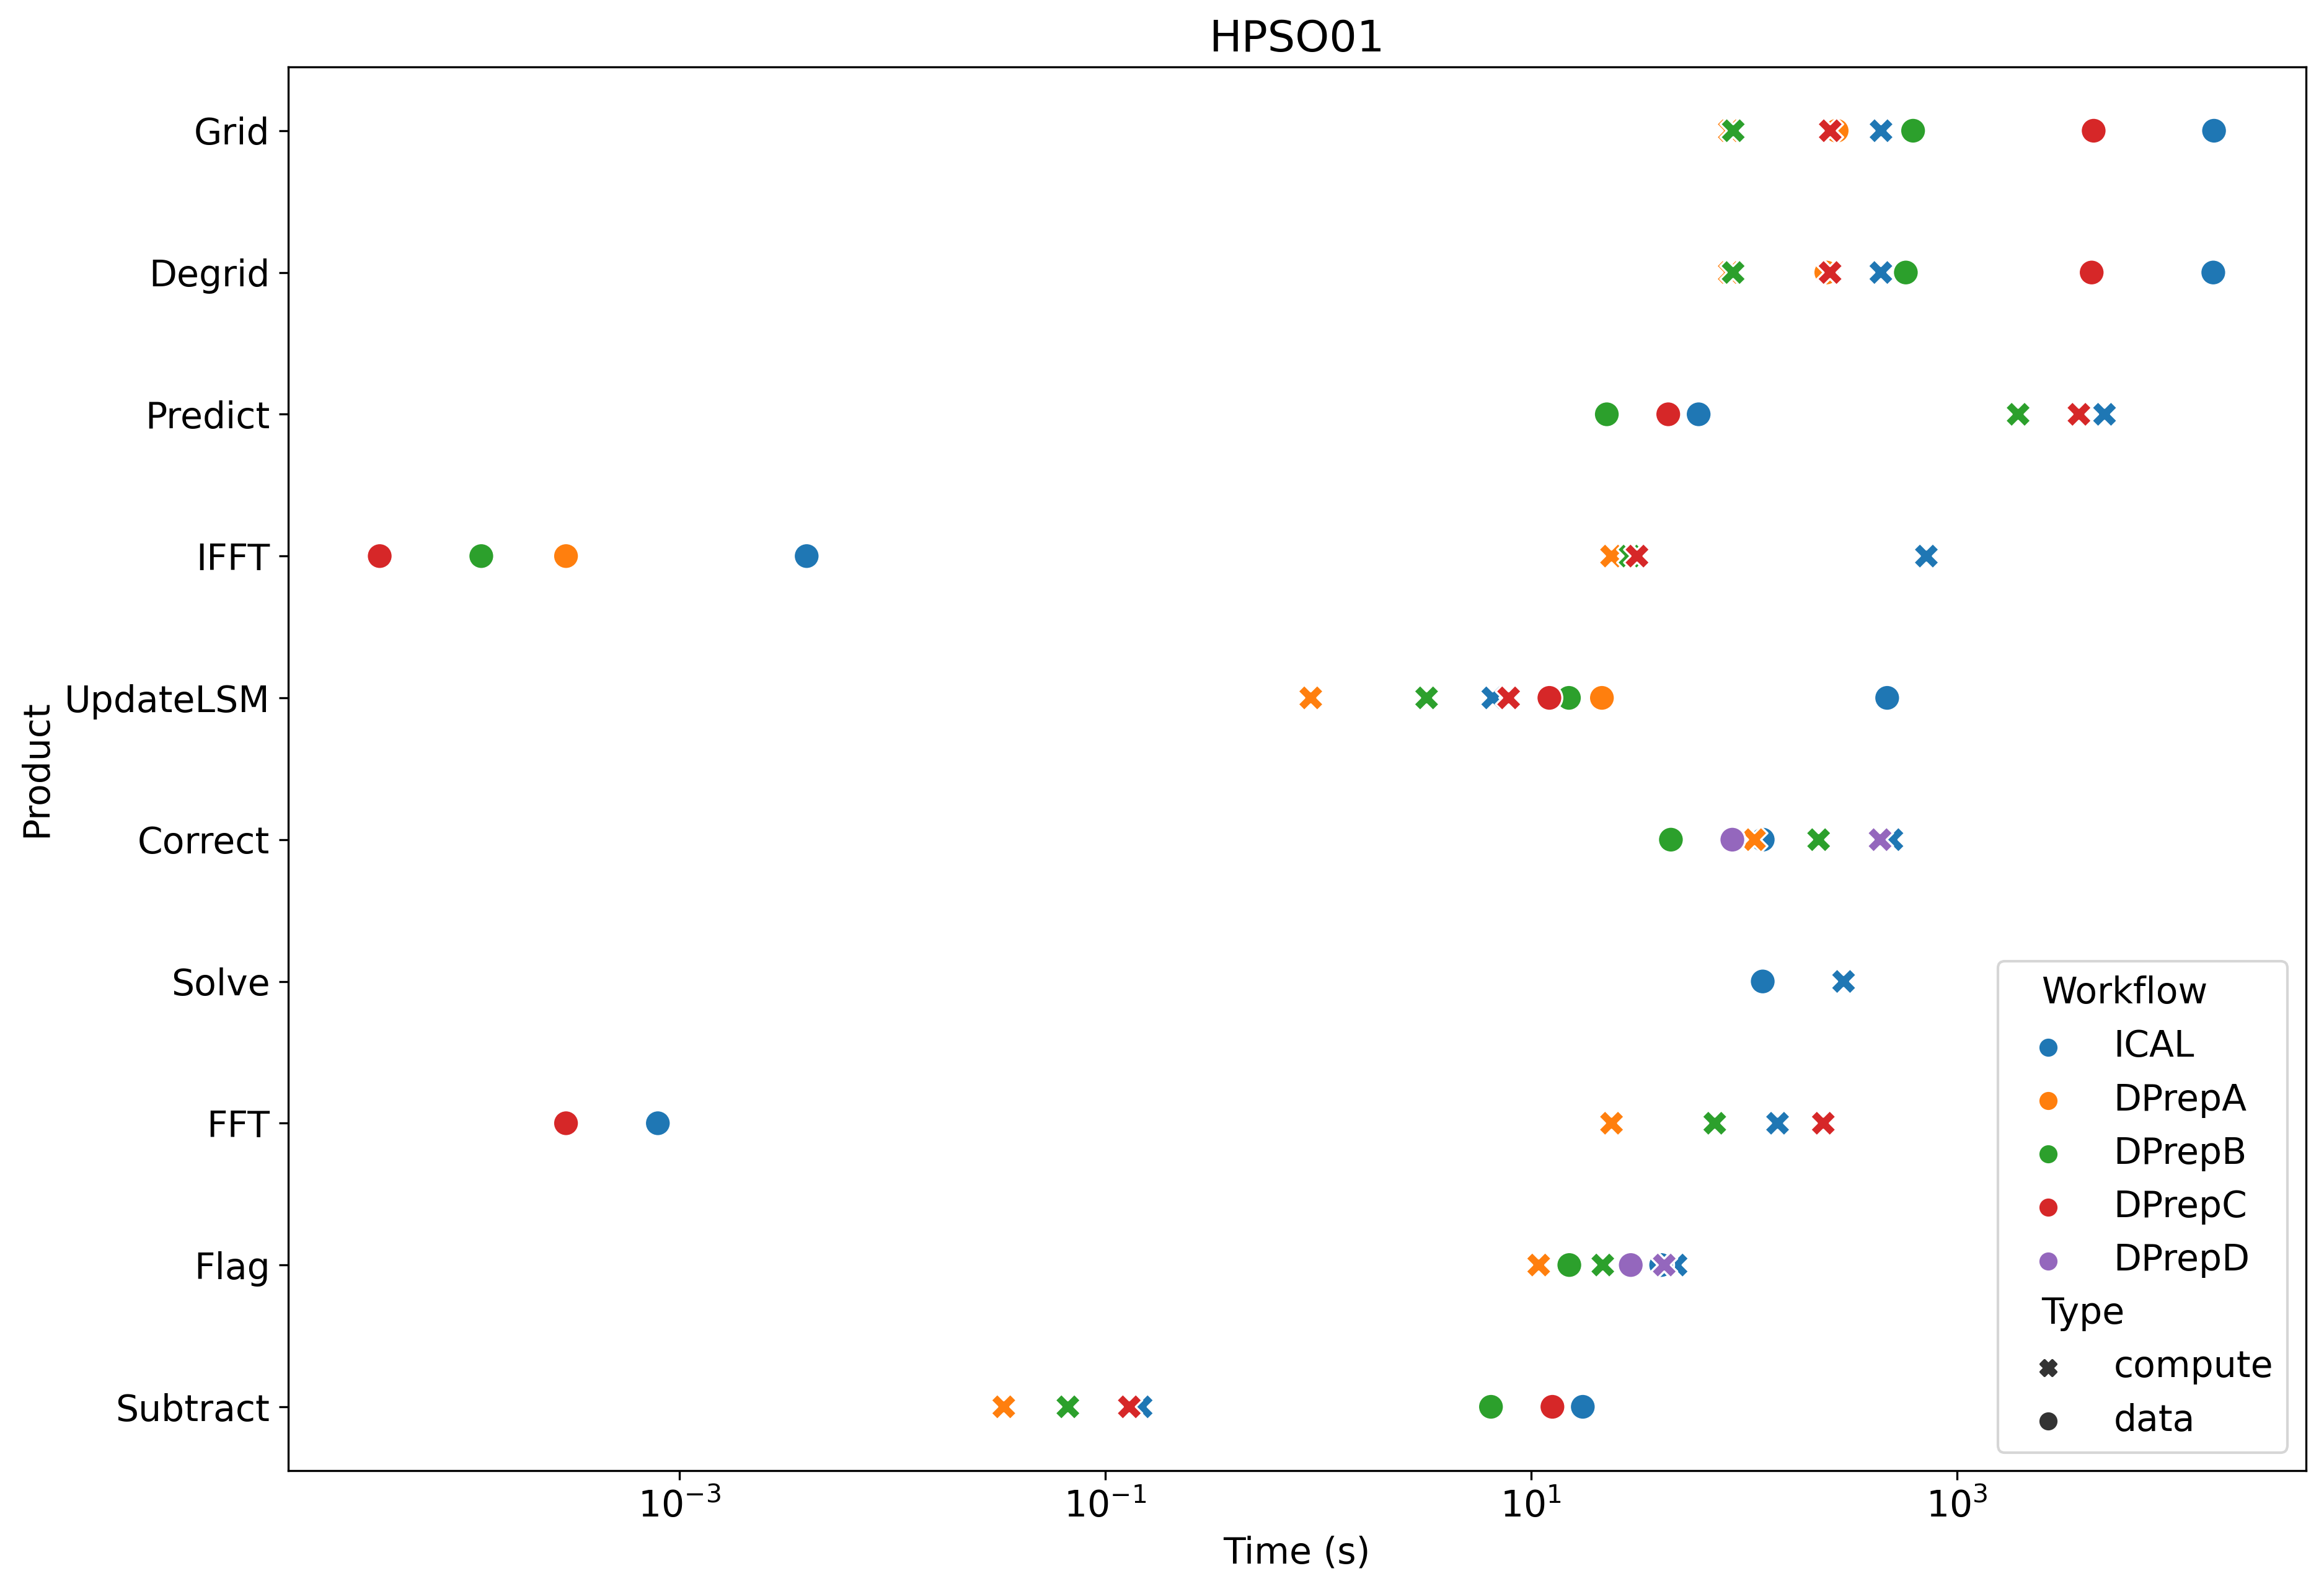

In [32]:
# For categorical plot, we want to reshape the data so the time is either compute or data
# i.e. rather than Product| workflow | Data time | compute time | , we have | product | workflow | time | type 
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(14,10),dpi=300)

hpso = 'hpso01'
df = hpso_dataframes[hpso]

df_comp = df[df['Type']== 'compute']
df_data = df[df['Type']== 'data']

g = sns.scatterplot(df, y='Product', x='Time (s)', hue='Workflow', style='Type', markers=['X', 'o'], s=100,)
# g = sns.catplot(df_data, y='Product', x='Time (s)', hue='Workflow', s=8, jitter=False, marker='P')
g.set_xscale("log")
# g.set_facecolor("none")
ax.set_title("HPSO01")
# for ax in g.fig.axes:
#     ax.set_xscale("log"))

plt.savefig("HPSORuntimeComparison.png")

/tmp/ipykernel_9483/3835923760.py:3: RuntimeWarning: invalid value encountered in true_divide
  df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))
/home/rwb/github/topsim/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_9483/3835923760.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = f.colorbar(res)


Text(0, 0.5, 'Ratio (I/O : FLOPs)')

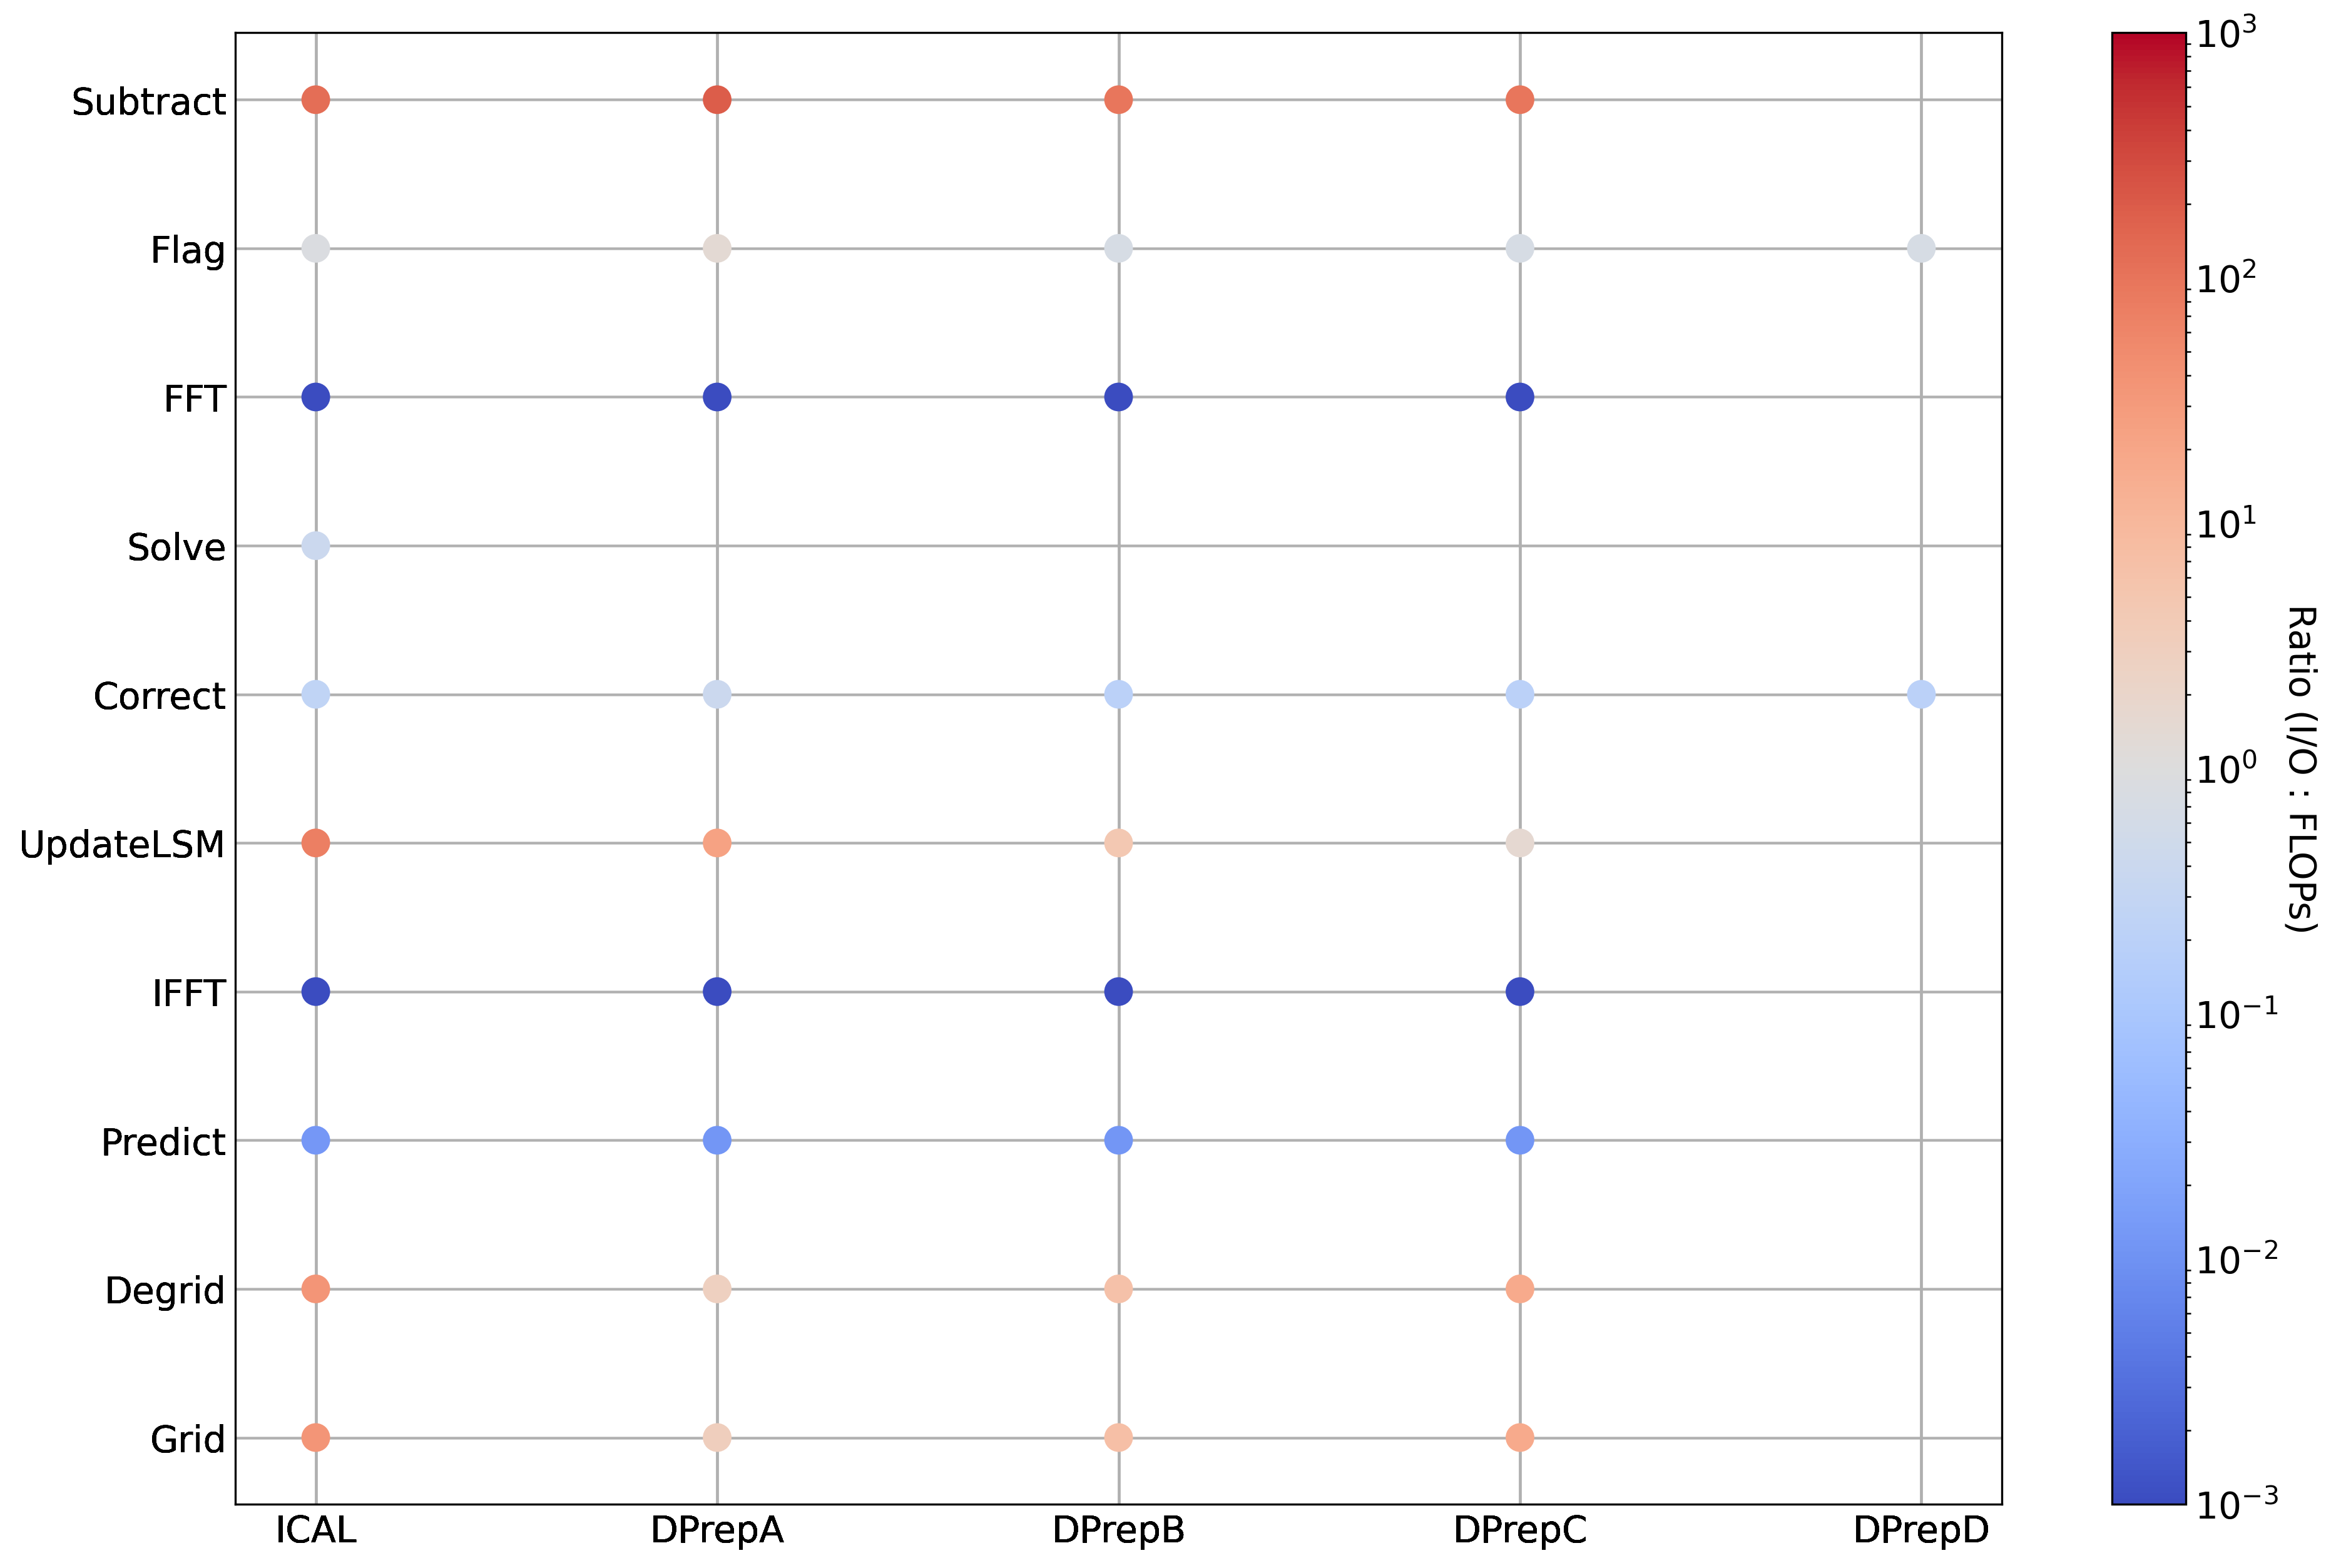

In [81]:
from matplotlib.colors import CenteredNorm, LogNorm, TwoSlopeNorm, Normalize
from matplotlib import cm
df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))

# df_comp.loc[:, "size"] = [( c/1 if c/1 > 1 else 1/c) for c in df_comp['ratio']]

f, ax = plt.subplots(figsize=(12,8),dpi=300)

class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)
    
# sizes = (df_comp['Time (s)'] - np.mean(df_comp['Time (s)']))/np.std(x)    
colorpalette = 'coolwarm'
norm = LogNorm(vmin=0.001, vmax=1000)
# midnorm = MidpointNormalize(0, vmax=df_comp['ratio'].max(),vcenter=50)
x = df_comp['Workflow']
y = df_comp['Product']

# norm = TwoSlopeNorm( vcenter=1, vmin=df_comp['ratio'].min(), vmax=200) # , vmin=df_comp['ratio'].min(), vmax=df_comp['ratio'].max())
res = ax.scatter(x,y , c=df_comp['ratio'], cmap=colorpalette, norm=norm, s=100)
ax.set_xticks(x)
ax.set_yticks(y)
ax.tick_params(direction='in')
# ax.grid(linestyle='--',)
cb = f.colorbar(res)
# f.colorbar(v, ax=ax)
# cb = ax.figure.colorbar(res)
# cb.ax.set_yscale('log')
# cb.set_ticks([0,1.0, 25.0])
# cb.
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Ratio (I/O : FLOPs)', rotation=270)


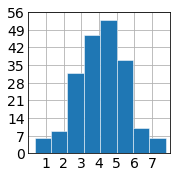

In [60]:
plt.style.use('_mpl-gallery')

# make data
np.random.seed(1)
x = 4 + np.random.normal(0, 1.5, 200)

# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=8, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 56), yticks=np.linspace(0, 56, 9))

plt.show()


0      209.419919
1       21.545259
2       15.081681
3       12.208980
4        0.000000
5       42.979882
6       23.906050
7       73.026540
8      236.142947
9        0.000000
10      32.035948
11      15.143920
12      21.753491
13      42.279729
14      42.279729
15     214.899411
16      23.906050
17      29.210616
18      31.485726
19       0.000000
20     330.693661
21     112.276082
22     224.552163
23     436.435911
24     436.435911
25    4652.273716
26     272.820479
27     623.654908
28    4396.609135
29       0.000000
30    4565.071904
31     244.011369
32     576.673094
33    4302.408001
34       0.000000
35    3031.946151
36    1936.775918
37    1942.080483
38    3749.308311
39       0.000000
40      11.682084
41       6.490251
42       6.490251
43      12.614347
44       0.000000
45     196.123729
46       0.000000
47       0.000000
48       0.000000
49       0.000000
dtype: float64

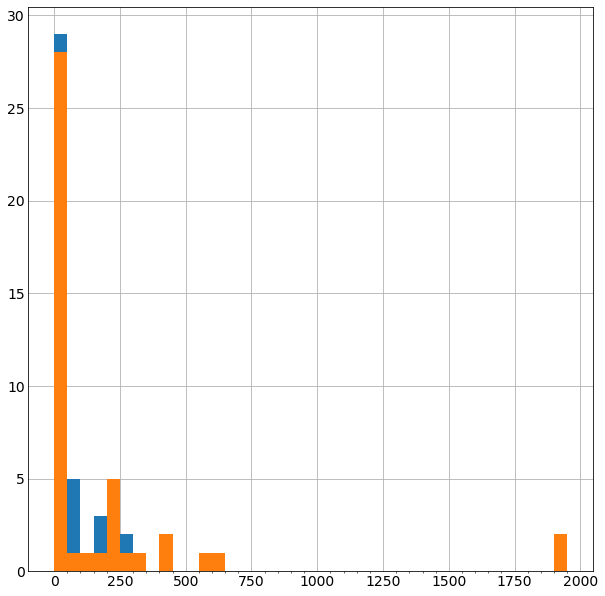

In [143]:
df_hpso01 = hpso_dataframes['hpso02a']
df_compute = df_hpso01[df_hpso01['Type'] == 'compute']
df_data = df_hpso01[df_hpso01['Type'] == 'data']

fix, ax = plt.subplots(figsize=(8,8))

bins = np.arange(0, 2000, 50)

ax.hist(df_compute['Time (s)'], bins, histtype='bar')

df_compute['Time (s)']
df_data['Time (s)']

df_max = pd.DataFrame({'compute': np.array(df_compute['Time (s)']), 'data': np.array(df_data['Time (s)'])}).max(axis=1)

# sorted(df_compute['Time (s)'])
ax.hist(df_max, bins, histtype='bar')
a =ax.set_xticks(ticks=bins,minor=True)

df_max